In [2]:
#@title imports
# print("installing packages")
# !pip install selfies===1.0.0
# !pip install rdkit-pypi
# !pip install -qU magenta
# !pip install music21===5.5.0
# !pip install matplotlib
# !pip install sklearn
#conda install tensorflow
#conda install -c conda-forge fluidsynth
#also need conda install -c conda-forge jupyterlab if not obvious

# !cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

# print("making folders")
# !mkdir wav
# !mkdir test
# !gunzip model.zip
print("imports")
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, rdMolDescriptors, Descriptors
import selfies
from music21.note import Note
from music21.chord import Chord
from music21.stream import Stream
from music21 import key as kyy
import matplotlib.pyplot as plt
import magenta.music as mm
import wave
import os
from magenta.models.music_vae import configs
from magenta.models.music_vae.trained_model import TrainedModel

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

imports


C:\Users\Ich\Git\samples\venv2\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\Ich\Git\samples\venv2\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\Ich\Git\samples\venv2\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defau

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
suppl = Chem.SDMolSupplier('structures.sdf')
selfs = {}
all_selfies = []
for k in suppl:
    try:
        Chem.SanitizeMol(k)
        sel = selfies.encoder(Chem.MolToSmiles(k))
    except:
        continue
    if sel == None: continue
    all_selfies.append(sel)
    for j in list(selfies.split_selfies(sel)):
        if j not in selfs:
            selfs[j] = 0
        selfs[j] = selfs[j] + 1
print(len(all_selfies))
ranked_selfies_tokens = (sorted(selfs.items(), key=lambda item: item[1], reverse=True))

[17:11:11] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[17:11:11] ERROR: Could not sanitize molecule ending on line 288741
[17:11:11] ERROR: Explicit valence for atom # 0 Cl, 5, is greater than permitted
[17:11:11] Explicit valence for atom # 39 N, 5, is greater than permitted
[17:11:11] ERROR: Could not sanitize molecule ending on line 327780
[17:11:11] ERROR: Explicit valence for atom # 39 N, 5, is greater than permitted
[17:11:12] Explicit valence for atom # 19 O, 3, is greater than permitted
[17:11:12] ERROR: Could not sanitize molecule ending on line 398763
[17:11:12] ERROR: Explicit valence for atom # 19 O, 3, is greater than permitted
[17:11:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:11:12] ERROR: Could not sanitize molecule ending on line 522182
[17:11:12] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
[17:11:12] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:11:12] ERROR: Could not sanitize 

11160


[17:11:18] Explicit valence for atom # 10 N, 4, is greater than permitted
[17:11:18] ERROR: Could not sanitize molecule ending on line 1873271
[17:11:18] ERROR: Explicit valence for atom # 10 N, 4, is greater than permitted


In [4]:
#@title physprops
def getAll(x): return [getMW(x), getLogP(x),getHBD(x),getHBA(x),getPSA(x),getROTB(x)]

	# return [getLogP(x),getMW(x),getHBD(x),getHBA(x),getPSA(x),getROTB(x),getFSP3(x),getFC(x),getQED(x)]

def getLogP(x): return Chem.rdMolDescriptors.CalcCrippenDescriptors(x)[0]
def getMW(x): return Chem.Descriptors.MolWt(x)
def getHBD(x): return Chem.rdMolDescriptors.CalcNumHBD(x)
def getHBA(x): return Chem.rdMolDescriptors.CalcNumHBA(x)
def getPSA(x): return Chem.rdMolDescriptors.CalcTPSA(x)
def getROTB(x): return Chem.rdMolDescriptors.CalcNumRotatableBonds(x)
def getAROM(x): return Chem.rdMolDescriptors.CalcNumAromaticRings(x)
def getFSP3(x): return Chem.rdMolDescriptors.CalcFractionCSP3(x)
def getFC(x): return Chem.rdmolops.GetFormalCharge(x)
def getQED(x): return Chem.QED.qed(x)

In [5]:
#@title main functions

print("mapping tokens to major scale")
note_to_shift = {}
shift_to_note = {}
# 2 2 1 2 2 2 1
major_scale = [0,2,4,5,7,9,11, \
               12,14,16,17,19,21,23, \
               24,26,28,29,31,33,35, \
               36,38,40,41,43,45,47, \
               48,50,52,53,55,57,59]
for i,k in enumerate(ranked_selfies_tokens[0:32]):
  note_to_shift[k[0]] = major_scale[i]
  shift_to_note[major_scale[i]] = k[0]

print("generating valid selfies from dataset")
valid_selfies_for_model = []
for i,k in enumerate(all_selfies):
  tpl = list(selfies.split_selfies(k))
  not_good = False
  for tok in tpl:
    if tok not in note_to_shift:
      not_good = True
      break
  if not_good:
    continue
  else:
    valid_selfies_for_model.append(k)
# print(len(valid_selfies_for_model))

def get_phys_prop_array(selfie):
  return getAll(Chem.MolFromSmiles(selfies.decoder(selfie)))

def hash_selfie(selfie):
  props = get_phys_prop_array(selfie)
  bit = 0
  for i,k in enumerate(props): bit = bit + k
  return bit

keys = ["G","C","D","A","Db","F","Ab","E","Bb","F#","B","Eb"]
def hash_to_key(hash, hashMin, hashMax):
  y = (((hash - hashMin) / (hashMax - hashMin)) * (len(keys) - 1)) + 0
  return keys[int(y)]

print("calculating max and min hash values")
hashes = []
for k in valid_selfies_for_model:
  hashes.append(hash_selfie(k))
minHash = np.min(hashes)
maxHash = np.max(hashes)

def create_wav_spectra(filename):
  signal_wave = wave.open('wav/'+str(filename)+'.wav', 'r')
  sample_rate = -1
  sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)
  sig = sig[:]

  left, right = sig[0::2], sig[1::2]

  plt.figure(1)

  plot_a = plt.subplot(111)
  plot_a.plot(sig)
  plot_a.set_xlabel('sample rate * time')
  plot_a.set_ylabel('amplitude')
  xt = [plot_a.get_xticks()[1], (plot_a.get_xticks()[1]+plot_a.get_xticks()[-2])/2,plot_a.get_xticks()[-2]]
  plot_a.set_xticks(xt)
  plot_a.set_yticks([plot_a.get_yticks()[0], 0, plot_a.get_yticks()[-1]])
  # plot_b = plt.subplot(212)
  # plot_b.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
  # plot_b.set_xlabel('Time')
  # plot_b.set_ylabel('Frequency')

  # plt.show()
  plt.tight_layout()
  # plt.show()
  plt.savefig(str(filename)+".png",dpi=300)
  # plt.close()

key_to_midi = {"C":48, "Db":49, "D": 50, "Eb":51, "E":52, "F":53, "F#":54, "G":55, "Ab":56, "A":57, "Bb":58, "B":59}
def create_midi_file(smiles, filename, directory="test", chords=True):
  ml = Chem.MolFromSmiles(smiles)
  Chem.SanitizeMol(ml)
  selfie = selfies.encoder(Chem.MolToSmiles(ml))
  print(selfie)

  key = hash_to_key(hash_selfie(selfie), np.min(hashes), np.max(hashes))
  note_pattern = []
  for tkn in selfies.split_selfies(selfie):
    note_pattern.append(note_to_shift[tkn])
  print(key)
  stream = Stream()
  stream.keySignature = kyy.Key(key, 'major')
  pitches = []
  for i,k in enumerate(note_pattern):
    pitch = key_to_midi[key] + k
    pitches.append(pitch)
    if chords:
      if i%4 == 0:
        chord = []
        idx = major_scale.index(k)
        chord.append(pitch)
        chord.append(key_to_midi[key]+major_scale[idx+2])
        chord.append(key_to_midi[key]+major_scale[idx+4])
        stream.append(Chord(chord, type='eighth'))
      else:
        stream.append(Note(pitch, type='eighth'))
    else:
        stream.append(Note(pitch, type='eighth'))
  stream.write('midi', directory+ '/' + str(filename) + ".mid")


mapping tokens to major scale
generating valid selfies from dataset
calculating max and min hash values


[C][C][C@expl][C][=C][C][N][C][C][C@expl][Branch2_1][Ring1][O][C][Branch1_2][=N][=C][Branch1_1][Branch1_3][C][Branch1_2][C][=O][O][C][C][Ring1][#C][N][C][=C][C][=C][C][=C][Ring1][Branch1_2][Ring1][#C][C@@Hexpl][Ring2][Ring1][Ring1][Ring2][Ring1][Branch1_3]
G


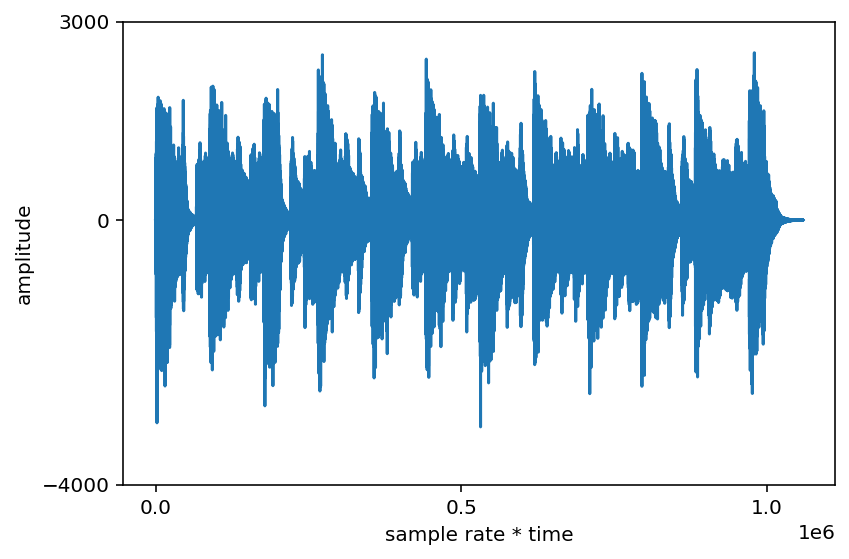

In [6]:
smiles =  "CC[C@]1(C=CC2)CC(C(OC)=O)=C([C@]34[C@@]1([H])N2CC3)NC5=C4C=CC=C5"#@param
filename = "9" #@param

create_midi_file(smiles, filename)
os.system("fluidsynth -ni font.sf2 test/"+filename+".mid -F wav/"+filename+".wav -r 44100")
create_wav_spectra(filename)

C:\Users\Ich\Git\samples\venv2\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  del sys.path[0]


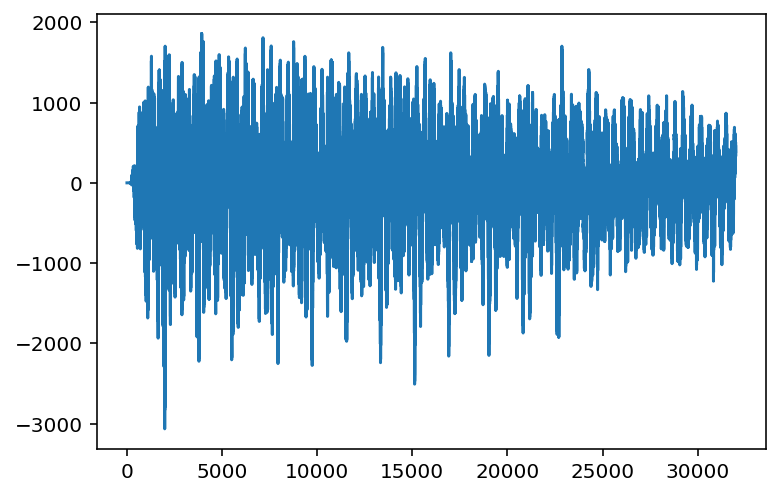

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys


spf = wave.open("wav/9.wav", "r")

# Extract Raw Audio from Wav File
sample_rate = 44100

signal = spf.readframes(16000)
signal = np.fromstring(signal, np.int16)


# # If Stereo
# if spf.getnchannels() == 2:
#     print("Just mono files")
#     sys.exit(0)

plt.figure(1)
# plt.title("Signal Wave...")
plt.plot(signal)
plt.show()

In [8]:
mel_2bar_config = configs.CONFIG_MAP['cat-mel_2bar_big']

input_mel_midi_data = [
    tf.io.gfile.GFile(fn, 'rb').read()
    for fn in sorted(tf.io.gfile.glob('./test/9.mid'))]
mel_input_seqs = [mm.midi_to_sequence_proto(m) for m in input_mel_midi_data]
extracted_mels=[]
for ns in mel_input_seqs:
  extracted_mels.extend(
          mel_2bar_config.data_converter.to_tensors(ns))


original
 CC[C@]1(C=CC2)CC(C(OC)=O)=C([C@]34[C@@]1([H])N2CC3)NC5=C4C=CC=C5
changing:[#C] to [O] at note 41 for key G
decoded
CC[C@]4C=CCN1CC[C@]3(C(=C(C(=O)OC)C1)NC2=CC=CC=C23)[C@@H]4 G


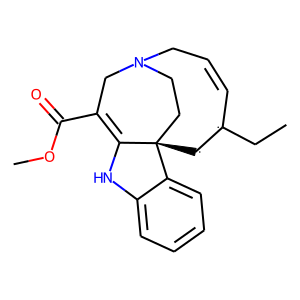

In [9]:
print("original\n", smiles)
# print(selfies.encoder(smiles))
gen, keys_map, streams = [], [], []
for j in key_to_midi:
  nts, nts_w_chrd = [], []
  not_valid = False
  n = 0
  for i,k in enumerate(mel_input_seqs[0].notes):
    note_number = 41 #@param {type:"slider", min:-1, max:55, step:1}
    set_note = 4 #@param {type:"slider", min:-1, max:31, step:1}

    if n == 1 or n == 2: 
      n = n + 1
      nts_w_chrd.append(k.pitch)
      continue 
    n = n + 1

    shft = k.pitch - key_to_midi[j]
    if shft not in shift_to_note:
      not_valid = True
      break

    if i == note_number and note_number > -1 and set_note > -1: 
      print("changing:" + shift_to_note[shft] + " to " + \
            shift_to_note[major_scale[set_note]] + " at note " + str(note_number) + \
            " for key " + j)
      shft = major_scale[set_note]
      nts_w_chrd.append(key_to_midi[j]+shft)
    else:
      nts_w_chrd.append(k.pitch)
    nts.append(shft)

    if n == 6: n = 0

  if not_valid: continue
  else:
    keys_map.append(j)
    gen.append(nts)

    stream = Stream()
    stream.keySignature = kyy.Key(j, 'major')
    chord = []
    n = 0
    for i,k in enumerate(nts_w_chrd):
      if n < 3:
        chord.append(k)
        n = n + 1
      if n == 3:
        stream.append(Chord(chord,type='eighth'))
        n = n + 1
        continue
      if n > 3 and n < 7:
        stream.append(Note(k,type='eighth'))
        n = n + 1
      if n == 7:
        chord = []
        n = 0
    streams.append(stream)
    stream.write('midi', 'test/morphD.mid')

print("decoded")
for i,k in enumerate(gen):
  se = []
  for j in k: se.append(shift_to_note[j])
  sel = "".join(se)
  ke = hash_to_key(hash_selfie(sel), np.min(hashes), np.max(hashes))
  if ke == keys_map[i]:
    print(selfies.decoder(sel), ke)
    streams[i].write('midi',"morphed.mid")
    try:
      mol = Chem.MolFromSmiles(selfies.decoder(sel))
      Chem.SanitizeMol(mol)
    except:
      print("failed")
Draw.MolToImage(mol)

In [12]:
#@title MusicVAE functions
# !unzip model.zip
mel_2bar_config = configs.CONFIG_MAP['cat-mel_2bar_big']
mel_2bar = TrainedModel(mel_2bar_config, batch_size=4, checkpoint_dir_or_path='./model/model.ckpt-10429')

def interpolate(model, start_seq, end_seq, num_steps, max_length=32,
                assert_same_length=True, temperature=0.5,
                individual_duration=4.0):
  """Interpolates between a start and end sequence."""
  note_sequences = model.interpolate(
      start_seq, end_seq,num_steps=num_steps, length=max_length,
      temperature=temperature,
      assert_same_length=assert_same_length)

  return note_sequences

def seq_to_smiles(seq):
  decoded = {}
  for j in key_to_midi:
    se = []
    for k in seq.notes:
      shift = k.pitch - key_to_midi[j]
      if shift in shift_to_note:
        se.append(shift_to_note[shift])
    decoded[j] = selfies.decoder("".join(se))
  return decoded

INFO:tensorflow:Building MusicVAE model with BidirectionalLstmEncoder, CategoricalLstmDecoder, and hparams:
{'max_seq_len': 32, 'z_size': 512, 'free_bits': 0, 'max_beta': 0.5, 'beta_rate': 0.99999, 'batch_size': 4, 'grad_clip': 1.0, 'clip_mode': 'global_norm', 'grad_norm_clip_to_zero': 10000, 'learning_rate': 0.001, 'decay_rate': 0.9999, 'min_learning_rate': 1e-05, 'conditional': True, 'dec_rnn_size': [2048, 2048, 2048], 'enc_rnn_size': [2048], 'dropout_keep_prob': 1.0, 'sampling_schedule': 'inverse_sigmoid', 'sampling_rate': 1000, 'use_cudnn': False, 'residual_encoder': False, 'residual_decoder': False, 'control_preprocessing_rnn_size': [256]}
INFO:tensorflow:
Encoder Cells (bidirectional):
  units: [2048]

INFO:tensorflow:
Decoder Cells:
  units: [2048, 2048, 2048]

INFO:tensorflow:Restoring parameters from ./model/model.ckpt-10429


In [13]:
key_count = {i:0 for i in keys}
qed_by_key = {i:[] for i in keys}
for k in valid_selfies_for_model:
  key = hash_to_key(hash_selfie(k), np.min(hashes), np.max(hashes))
  key_count[key] += 1
  qed = getQED(Chem.MolFromSmiles(selfies.decoder(k)))
  qed_by_key[key].append(qed)


G 7951 0.5729580314357604
C 899 0.17907760110117046
D 124 0.04962847975898997
A 37 0.02457646657965332
Db 9 0.012694743279173519
F 6 0.017006653824169982
Ab 1 0.0095786091091358
E 2 0.012485505400823441
F# 1 0.0096257262911143
Eb 1 0.015742586341330838


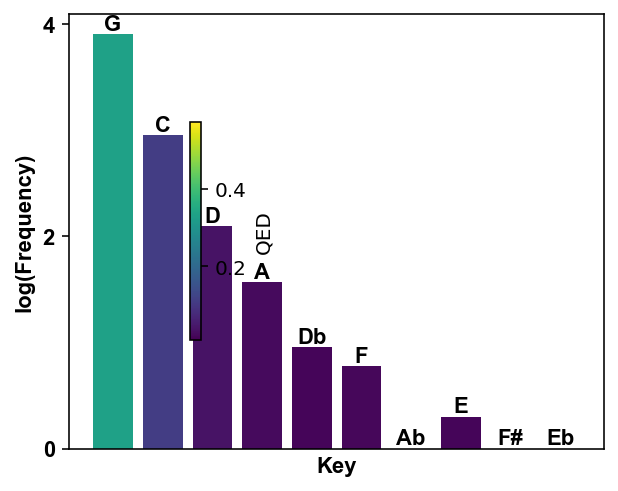

In [14]:
cmap=plt.get_cmap("viridis")


bars = []
cols = []
labels = []
qeds = []
for k in key_count:
  if key_count[k] > 0:
    print(k, key_count[k], np.mean(qed_by_key[k]))
    bars.append(key_count[k])
    cols.append(cmap(np.mean(qed_by_key[k])))
    qeds.append(np.mean(qed_by_key[k]))
    labels.append(k)

bar1 = plt.bar(range(0,len(bars)),np.log10(bars), color=cols)
plt.xticks(range(0,len(bars)), labels, fontsize=6, fontname="arial")
plt.xticks([])
plt.xlabel("Key", fontsize=11, fontname="arial",weight='bold')
plt.yticks([0,2,4],fontsize=11, fontname="arial",weight='bold')
plt.ylabel("log(Frequency)", fontsize=11, fontname="arial",weight='bold')
for i,rect in enumerate(bar1) :
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, labels[i], fontsize=11, fontname="arial",ha='center', va='bottom',weight='bold')
# plt.xtickl
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=np.min(qeds), vmax=np.max(qeds))

plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             orientation='vertical', label='QED', shrink=.5,anchor=(-5,.5))
plt.savefig("graph.png",dpi=300)


In [15]:
from rdkit.Chem import DataStructs, AllChem
drug_keys = []
fps = []
valid_smiles = []
for k in valid_selfies_for_model:
  key = hash_to_key(hash_selfie(k), np.min(hashes), np.max(hashes))
  drug_keys.append(key)
  mol = Chem.MolFromSmiles(selfies.decoder(k))
  valid_smiles.append(Chem.MolToSmiles(mol))
  nfp = np.zeros((1,))
  DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 2,nBits=512), nfp)
  fps.append(nfp)

In [16]:
from sklearn.manifold import TSNE

X = TSNE(n_components=2, n_jobs=-1).fit_transform(fps)

C:\Users\Ich\Git\samples\venv2\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\Ich\Git\samples\venv2\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [17]:
drug_keys_one_hot = []
morph = Chem.MolToSmiles(Chem.MolFromSmiles("OC1=C2O[C@@H]3[C@]45C2=C(C=C1)C[C@@H](N(CC5)C)[C@]4([H])C=C[C@@H]3O"))
code = Chem.MolToSmiles(Chem.MolFromSmiles("COC1=C2O[C@@H]3[C@]45C2=C(C=C1)C[C@@H](N(CC5)C)[C@]4([H])C=C[C@@H]3O"))

sulfadoxin = Chem.MolToSmiles(Chem.MolFromSmiles("NC1=CC=C(S(NC2=C(OC)C(OC)=NC=N2)(=O)=O)C=C1"))
sulfamethoxazole = Chem.MolToSmiles(Chem.MolFromSmiles("NC1=CC=C(S(NC2=NOC(C)=C2)(=O)=O)C=C1"))

ketorolac = Chem.MolToSmiles(Chem.MolFromSmiles("OC(C1CCN2C1=CC=C2C(C3=CC=CC=C3)=O)=O"))
tolmetin = Chem.MolToSmiles(Chem.MolFromSmiles("CN1C(CC(O)=O)=CC=C1C(C2=CC=C(C=C2)C)=O"))

vindoline = Chem.MolToSmiles(Chem.MolFromSmiles("CN1C2=CC(OC)=CC=C2[C@@]3(CC4)C1[C@@](O)(C(OC)=O)[C@H](OC(C)=O)[C@@]5(CC)C3N4CC=C5"))
tabersonine = Chem.MolToSmiles(Chem.MolFromSmiles("CC[C@]1(C=CC2)CC(C(OC)=O)=C([C@]34[C@@]1([H])N2CC3)NC5=C4C=CC=C5"))


buckets = {}
for i,k in enumerate(drug_keys):
  # print(keys.index(k))
  if k not in buckets:
    buckets[k] = []
  buckets[k].append(X[i])
  if valid_smiles[i] == morph: print("morph", i, X[i])
  if valid_smiles[i] == code: print("code", i, X[i])
  if valid_smiles[i] == sulfadoxin: print("sulfadoxin", i, X[i])
  if valid_smiles[i] == sulfamethoxazole: print("sulfamethoxazole", i, X[i])

  if valid_smiles[i] == ketorolac: print("ketorolac", i, X[i])
  if valid_smiles[i] == tolmetin: print("tolmetin", i, X[i])

  if valid_smiles[i] == vindoline: print("vindoline", i, X[i])
  if valid_smiles[i] == tabersonine: print("tabersonine", i, X[i])

  drug_keys_one_hot.append(keys.index(k))

buckets_sort = sorted(buckets, key=lambda k: len(buckets[k]), reverse=True)


morph 169 [-57.34569  57.18171]
code 191 [-57.37621   56.788242]
ketorolac 315 [17.647232 25.64184 ]
tolmetin 343 [35.18944   -3.5694716]
sulfamethoxazole 779 [-19.80412  53.1359 ]
sulfadoxin 1004 [-19.73947   55.590298]


In [18]:
fps_code = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(code), 2,nBits=512)
fps_morph = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(morph), 2,nBits=512)

fps3 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("CC1=CC=C(C(=O)NC2CC2)C=C1C3=CC=C4N=C(NCCN5CCOCC5)N=CC4=C3"), 2,nBits=512)
fps4 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("CC1=CC=C(C(=O)C2=CC=C(CC(=O)NCC(=O)O)N2C)C=C1"), 2,nBits=512)
fps5 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("CC=1[NH1]C2=CC=CC=C2C=1CCNCC3=CC=C(/C=C/C(=O)NO)C=C3"), 2,nBits=512)


fps_sulfadoxin = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(sulfadoxin), 2,nBits=512)
fps_sulfamethoxazole = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(sulfamethoxazole), 2,nBits=512)

fps8 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("N[C@@H1](CCC(=O)NC1=CC=C(OCC2=CC=CC=C2)C=C1)C(=O)O"), 2,nBits=512)
fps9 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("O=C(O)COC1=CC(F)=CC=C1C(=O)NCC2=NC3=C(F)C(F)=CC(F)=C3S2"), 2,nBits=512)
fps10 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("NCCCCNC(=O)C1=CC=C(S(N)(=O)=O)C=C1"), 2,nBits=512)


fps_tolmetin = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(tolmetin), 2,nBits=512)
fps_ketorolac = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(ketorolac), 2,nBits=512)

fps13 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("CCN1N=CC=C1C2=C[NH1]C3=NC=C(C4=CC=C(N)C(C(=O)N(C)C)=C4)C=C23"), 2,nBits=512)
fps14 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("O=CCCCC=C(C=O)CCC=C(C=O)CCC=O"), 2,nBits=512)
fps15 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("C[C@H1]1[C@H1]2CC3=CC=C(O)C=C3[C@]1(C)CCN2CCC4=CC=CC=C4"), 2,nBits=512)


fps_vindoline = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(vindoline), 2,nBits=512)
fps_tabersonine = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(tabersonine), 2,nBits=512)

fps18 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("CCN[C@@H1](C)CC1=CC=CC(C(F)(F)F)=C1"), 2,nBits=512)
fps19 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("CC(C)=CCC/C(C)=C/CC/C(C)=C/COP(=O)(O)OP(=O)(O)O"), 2,nBits=512)
fps20 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("O=C(CCCN1CCC(N2C(O)=NC3=CC=CC=C32)CC1)C4=CC=C(F)C=C4"), 2,nBits=512)

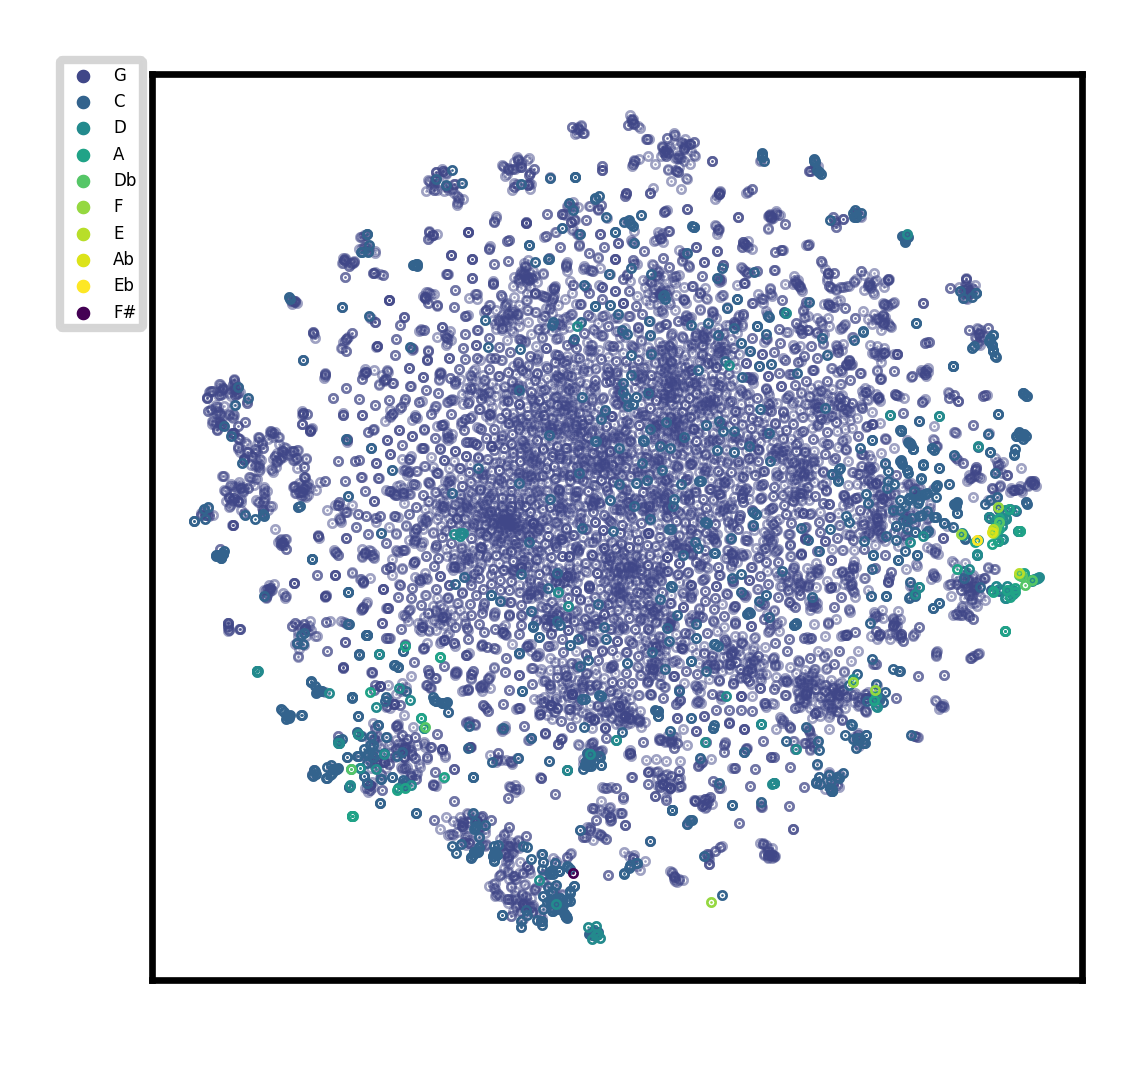

In [19]:
fig, ax = plt.subplots(figsize=(2,2), dpi=300)
colors = ["#404788", "#33638D", "#238A8D", "#20A387", "#55C667", "#95D840", "#B8DE29", "#DCE319", "#FDE725","#440154"]
n = 0
for i,k in enumerate(buckets_sort):
  if i == 0:
    alpha = .5
  else:
    alpha = 1
  ax.scatter(np.array(buckets[k])[:,0],np.array(buckets[k])[:,1], cmap='plasma', s=.1, alpha=alpha, color=colors[i], label=k, zorder=n)
  n = n + 1

ax.set_xticks([])
ax.set_yticks([])

leg = ax.legend(bbox_to_anchor=(-0, 1.025), fontsize=2, markerscale=2)
for legend_handle in leg.legendHandles:
    legend_handle.set_alpha(1)

plt.show()



In [20]:
# !rm -r test
# !mkdir test
checker = {}

# fig_mols = ["NC(CC[C@@H](C(O)=O)N)=O", "NC(OCC[N+](C)(C)C)=O", "NC(OC(CC)(C)CC)=O", "O=C(C1=CC=CC=C1O)OCC", 
            # "C=C([C@H]1CC=C(CC1)C)C", "O[C@H]1OC[C@H]([C@@H]([C@H]1O)O)O", "FC[C@H](C[C@@H](C(O)=O)N)C", "O[C@H]1CO[C@@H]2[C@@H](CO[C@H]12)O"]
# fig_mols = ["NCCCCC(OC=O)=O", "ONC1CCCCN1CCC"]
fig_mols = ["N", "C1=CC=CC=C1", "NC1=CC=CC=C1", "C12=CC=CC=C1NC=C2", "OC(C1CCN2C1=CC=C2C(C3=CC=CC=C3)=O)=O", \
            "CN1C(CC(O)=O)=CC=C1C(C2=CC=C(C=C2)C)=O", "CC[C@]1(C=CC2)CC(C(OC)=O)=C([C@]34[C@@]1([H])N2CC3)NC5=C4C=CC=C5", \
            "CN1C2=CC(OC)=CC=C2[C@@]3(CC4)C1[C@@](O)(C(OC)=O)[C@H](OC(C)=O)[C@@]5(CC)C3N4CC=C5"]
# fig_mols = ["N[C@@H](CC(C)C)C(O)=O", "O[C@H]1[C@@H]2[C@@H]([C@@H](O)CO2)OC1"]

for i,sm in enumerate(fig_mols):
  sm = Chem.MolToSmiles(Chem.MolFromSmiles(sm))
  filename = "fig1-"+str(i+1)+"wav"
  checker["./test/"+str(i)+".mid"] = sm
  create_midi_file(sm, filename, chords=True)
  os.system("fluidsynth -ni font.sf2 test/"+filename+".mid -F wav/"+filename+".wav -r 44100")
  create_wav_spectra(filename)
  plt.close()

[N]
G
[C][=C][C][=C][C][=C][Ring1][Branch1_2]
G
[N][C][=C][C][=C][C][=C][Ring1][Branch1_2]
G
[C][C][=C][C][NHexpl][C][=C][C][Expl=Ring1][Branch1_1][C][Expl=Ring1][Branch2_2]
G
[O][=C][Branch1_1][Branch2_2][C][=C][C][=C][C][=C][Ring1][Branch1_2][C][=C][C][=C][N][Ring1][Branch1_1][C][C][C][Ring1][Branch1_1][C][Branch1_2][C][=O][O]
G
[C][C][=C][C][=C][Branch2_1][Ring1][Branch1_1][C][Branch1_2][C][=O][C][=C][C][=C][Branch1_1][Branch1_3][C][C][Branch1_2][C][=O][O][N][Ring1][Branch2_2][C][C][=C][Ring2][Ring1][C]
G
[C][C][C@expl][C][=C][C][N][C][C][C@expl][Branch2_1][Ring1][O][C][Branch1_2][=N][=C][Branch1_1][Branch1_3][C][Branch1_2][C][=O][O][C][C][Ring1][#C][N][C][=C][C][=C][C][=C][Ring1][Branch1_2][Ring1][#C][C@@Hexpl][Ring2][Ring1][Ring1][Ring2][Ring1][Branch1_3]
G
[C][C][C@expl][C][=C][C][N][C][C][C@@expl][Branch2_1][Ring2][Branch2_3][C][=C][C][=C][Branch1_1][Ring1][O][C][C][=C][Ring1][Branch2_1][N][Branch1_1][C][C][C][Ring1][N][C@@expl][Branch1_1][C][O][Branch1_1][Branch1_3][C][Branch1_

In [21]:
input_mel_midi_data = [
    tf.io.gfile.GFile(fn, 'rb').read()
    for fn in sorted(tf.io.gfile.glob('./test/*.mid'))]
mel_input_seqs = [mm.midi_to_sequence_proto(m) for m in input_mel_midi_data]
extracted_mels = []
for ns in mel_input_seqs:
  extracted_mels.extend(
      mel_2bar_config.data_converter.from_tensors(
          mel_2bar_config.data_converter.to_tensors(ns)[1]))
files = [fn for fn in sorted(tf.io.gfile.glob('./test/*.mid'))]

In [22]:
i1 = 0
i2 = 1
start_mel = extracted_mels[i1]
end_mel = extracted_mels[i2]
temperature = .1
num_steps =  3

mel_2bar_interp = interpolate(mel_2bar, start_mel, end_mel, num_steps=num_steps, temperature=temperature)

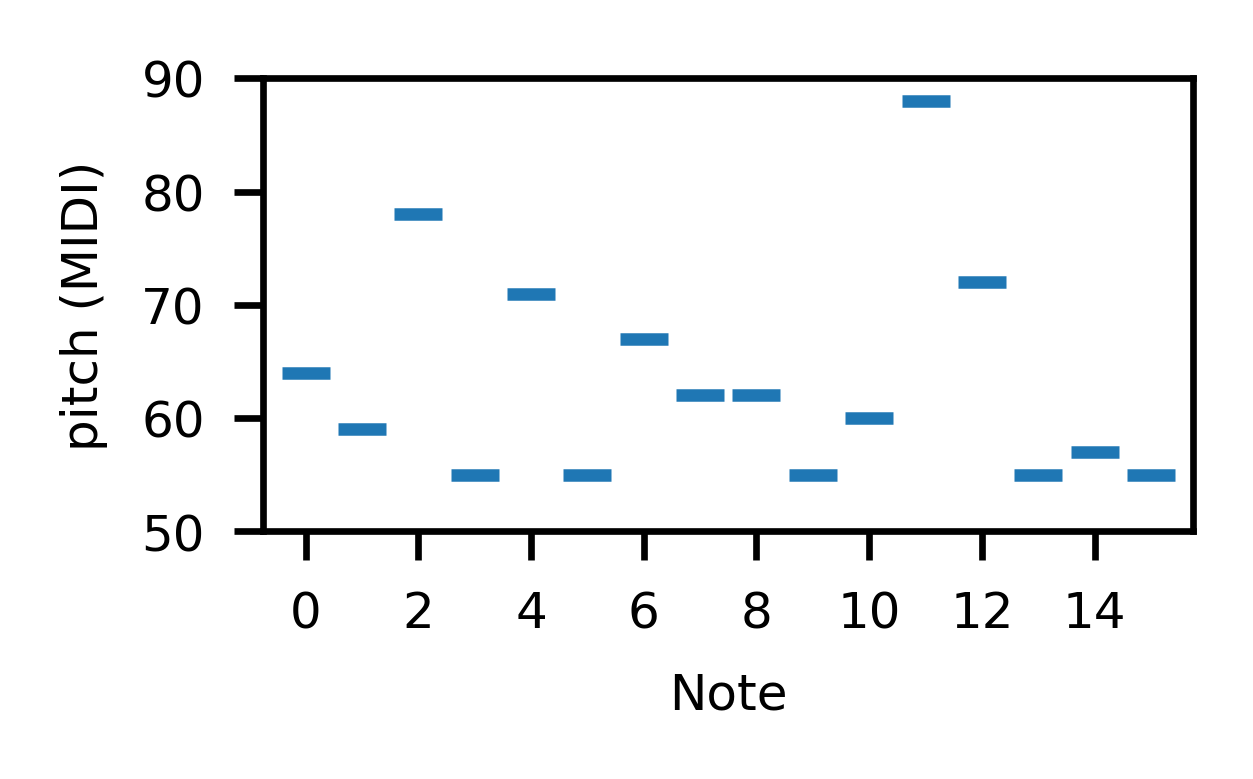

In [23]:
x = []
y = []
fig, ax = plt.subplots(figsize=(2,1), dpi=300)

for i,k in enumerate(start_mel.notes):
  x.append(i)
  y.append(k.pitch)
  
ax.scatter(x,y, marker='_', s=32)
ax.set_xlabel("Note", fontsize=6)
ax.set_ylabel("pitch (MIDI)", fontsize=6)
ax.set_yticks([50,60,70,80,90])
ax.set_yticklabels(ax.get_yticks(), fontsize=6)
ax.set_xticks(range(0,16,2))
ax.set_xticklabels(ax.get_xticks(), fontsize=6)
plt.show()

In [24]:
for k in mel_2bar_interp:
  out = seq_to_smiles(k)
  print(out["G"])


COCCOOC(=O)
ClCNOS[C@H]=O
C#CO


In [25]:
input_mel_midi_data = [
    tf.io.gfile.GFile(fn, 'rb').read()
    for fn in sorted(tf.io.gfile.glob('*.mid'))]
mel_input_seqs = [mm.midi_to_sequence_proto(m) for m in input_mel_midi_data]


In [26]:
for j in keys:
  key = key_to_midi[j]
  se = []
  try:
    n = 0
    for i,k in enumerate(mel_input_seqs[0].notes):
      se.append(shift_to_note[k.pitch-key])
      n = n + 1
  except:
    continue
  print(j)
  print(selfies.decoder("".join(se)))

G
C(C[C@]C=CCNCC)([C@]1(N=NC))(C2([C@H])C=O)OC2(C1N=CC=C)C=C=O


In [27]:
notes2 = [60, 60, 67, 67, 69, 69, 67, 65, 65, 64, 64, 62, 62, 60, \
         67, 67, 65, 65, 64, 64, 62, 67, 67, 65, 65, 64, 64, 62]
notes = []
for j in notes2:
  notes.append(j)
key = key_to_midi["Db"]
se = []
shifts = []
for k in notes:
  if int(k-key) not in shift_to_note:
    # print(k, k-key)
    # key = key 
    # print(k)
    if k == 62:
      se.append("[Ring2]")
    if k == 64:
      se.append("[C]")
    if k == 67:
      se.append("[Branch2_1]")
    # if k == 69:
    #   se.append("[Branch2_2]")
    continue
  # print(shift_to_note[k-key])
  shifts.append([k-key])
  # print(shift_to_note[k-key])
  se.append(shift_to_note[k-key])
selfies.decoder("".join(se))

'N12N([C@H][C@H]CC1([C@H]CC2[C@H][C@H]C=C))'

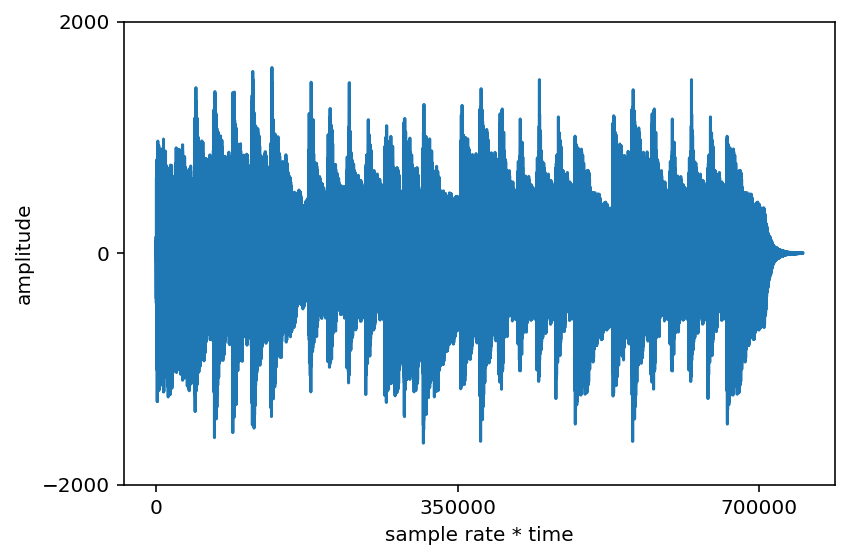

In [28]:
stream = Stream()
stream.keySignature = kyy.Key("Db", 'major')
for i,k in enumerate(notes2):
  if i == 6:
    stream.append(Note(k, type='quarter'))
  elif i == 13 or i == 20 or i == 27:
    stream.append(Note(k, type='quarter'))
  else:
    stream.append(Note(k, type='eighth'))
stream.write('midi', "test/twinkle.mid")
filename="twinkle"
os.system("fluidsynth -ni font.sf2 test/"+filename+".mid -F wav/"+filename+".wav -r 44100")

create_wav_spectra("twinkle")

In [29]:
mm.plot_sequence(start_mel)
mm.plot_sequence(end_mel)

Loading BokehJS ...

Loading BokehJS ...